<a href="https://colab.research.google.com/github/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/CIFAR10_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
# Which GPU?
!nvidia-smi

Sun May  3 07:35:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import time

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [0]:
def get_training_model():
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)
    
    return model

In [0]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	with plt.xkcd():
		plt.figure()
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [0]:
# Load the training set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
BATCH_SIZE = 128

def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
model = get_training_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
__________________________________________________________________________________________________
re_lu_164 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_164[0][0]    
____________________________________________________________________________________________

- Total params: 575,114
- Trainable params: 571,114
- Non-trainable params: 4,000


Epoch 1/75
391/391 [==============================] - 15s 39ms/step - loss: 2.1497 - accuracy: 0.2026 - val_loss: 2.0214 - val_accuracy: 0.2275
Epoch 2/75
391/391 [==============================] - 14s 37ms/step - loss: 1.9578 - accuracy: 0.2725 - val_loss: 1.8603 - val_accuracy: 0.3016
Epoch 3/75
391/391 [==============================] - 14s 37ms/step - loss: 1.8590 - accuracy: 0.3065 - val_loss: 1.7817 - val_accuracy: 0.3285
Epoch 4/75
391/391 [==============================] - 14s 37ms/step - loss: 1.8006 - accuracy: 0.3270 - val_loss: 1.7104 - val_accuracy: 0.3516
Epoch 5/75
391/391 [==============================] - 14s 37ms/step - loss: 1.7557 - accuracy: 0.3440 - val_loss: 1.7278 - val_accuracy: 0.3506
Epoch 6/75
391/391 [==============================] - 15s 37ms/step - loss: 1.7251 - accuracy: 0.3571 - val_loss: 1.6611 - val_accuracy: 0.3748
Epoch 7/75
391/391 [==============================] - 14s 37ms/step - loss: 1.6976 - accuracy: 0.3679 - val_loss: 1.6150 - val_accuracy:

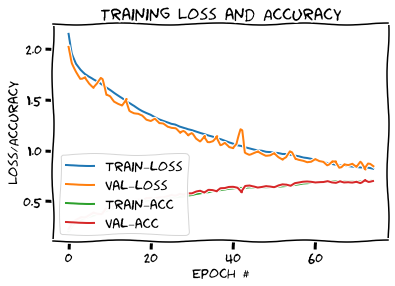

In [0]:
# Train model
model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75)
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [0]:
# Save the weights to GCS bucket for reproducibility
PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

from google.colab import auth as google_auth
google_auth.authenticate_user()

In [0]:
!gsutil mb gs://batch_norm

Creating gs://batch_norm/...


In [0]:
model.save("vanilla_resnet")
!gsutil -m cp -r vanilla_resnet gs://batch_norm

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vanilla_resnet/assets
Copying file://vanilla_resnet/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://vanilla_resnet/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://vanilla_resnet/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://vanilla_resnet/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
/ [4/4 files][  3.9 MiB/  3.9 MiB] 100% Done                                    
Operation completed over 4 objects/3.9 MiB.                                      


Epoch 1/75
391/391 [==============================] - 14s 37ms/step - loss: 1.8414 - accuracy: 0.3135 - val_loss: 1.7982 - val_accuracy: 0.3394
Epoch 2/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5850 - accuracy: 0.4167 - val_loss: 1.4672 - val_accuracy: 0.4633
Epoch 3/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5165 - accuracy: 0.4494 - val_loss: 1.4210 - val_accuracy: 0.4781
Epoch 4/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5117 - accuracy: 0.4509 - val_loss: 1.4210 - val_accuracy: 0.4783
Epoch 5/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5094 - accuracy: 0.4516 - val_loss: 1.4210 - val_accuracy: 0.4785
Epoch 6/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5095 - accuracy: 0.4491 - val_loss: 1.4209 - val_accuracy: 0.4787
Epoch 7/75
391/391 [==============================] - 14s 36ms/step - loss: 1.5150 - accuracy: 0.4489 - val_loss: 1.4210 - val_accuracy:

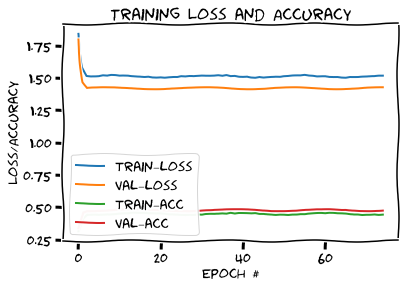

In [0]:
# Train model with a decay schedule
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecay(
      initial_learning_rate=0.1,
      decay_steps=first_decay_steps))

model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr_decayed_fn), metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75)
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [0]:
model.save("resnet_lrsch_1")
!gsutil -m cp -r resnet_lrsch_1 gs://batch_norm

INFO:tensorflow:Assets written to: resnet_lrsch_1/assets
Copying file://resnet_lrsch_1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_1/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_1/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_1/variables/variables.index [Content-Type=application/octet-stream]...
/ [4/4 files][  3.9 MiB/  3.9 MiB] 100% Done                                    
Operation completed over 4 objects/3.9 MiB.                                      


Epoch 1/75
391/391 [==============================] - 14s 37ms/step - loss: 1.8823 - accuracy: 0.2932 - val_loss: 1.8831 - val_accuracy: 0.2946
Epoch 2/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6850 - accuracy: 0.3755 - val_loss: 1.5842 - val_accuracy: 0.4137
Epoch 3/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6551 - accuracy: 0.3878 - val_loss: 1.5780 - val_accuracy: 0.4184
Epoch 4/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6546 - accuracy: 0.3897 - val_loss: 1.5774 - val_accuracy: 0.4185
Epoch 5/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6536 - accuracy: 0.3894 - val_loss: 1.5774 - val_accuracy: 0.4180
Epoch 6/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6533 - accuracy: 0.3893 - val_loss: 1.5774 - val_accuracy: 0.4191
Epoch 7/75
391/391 [==============================] - 14s 36ms/step - loss: 1.6493 - accuracy: 0.3909 - val_loss: 1.5771 - val_accuracy:

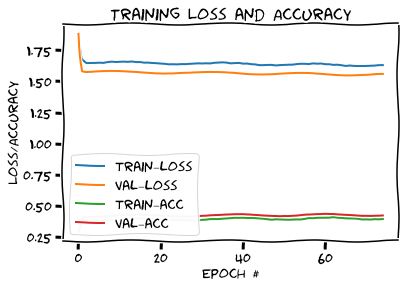

In [0]:
# Train model with a different decay schedule
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.LinearCosineDecay(
      initial_learning_rate=0.1,
      decay_steps=first_decay_steps))

model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr_decayed_fn), metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75)
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [0]:
model.save("resnet_lrsch_2")
!gsutil -m cp -r resnet_lrsch_2 gs://batch_norm

INFO:tensorflow:Assets written to: resnet_lrsch_2/assets
Copying file://resnet_lrsch_2/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_2/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_2/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://resnet_lrsch_2/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
/ [4/4 files][  3.9 MiB/  3.9 MiB] 100% Done                                    
Operation completed over 4 objects/3.9 MiB.                                      


In [0]:
model = get_training_model()

for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        if hasattr(layer, "trainable"):
            layer.trainable=False

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_244 (BatchN (None, 32, 32, 16)   64          conv2d_254[0][0]                 
__________________________________________________________________________________________________
re_lu_244 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_244[0][0]    
____________________________________________________________________________________________

- Total params: 575,114
- **Trainable params: 4,000**
- Non-trainable params: 571,114

Epoch 1/75
391/391 [==============================] - 11s 29ms/step - loss: 2.4399 - accuracy: 0.0947 - val_loss: 2.3885 - val_accuracy: 0.0918
Epoch 2/75
391/391 [==============================] - 11s 28ms/step - loss: 2.3831 - accuracy: 0.0969 - val_loss: 2.3658 - val_accuracy: 0.0910
Epoch 3/75
391/391 [==============================] - 11s 28ms/step - loss: 2.3502 - accuracy: 0.0989 - val_loss: 2.3353 - val_accuracy: 0.0920
Epoch 4/75
391/391 [==============================] - 11s 28ms/step - loss: 2.3248 - accuracy: 0.1044 - val_loss: 2.3130 - val_accuracy: 0.0988
Epoch 5/75
391/391 [==============================] - 11s 28ms/step - loss: 2.3083 - accuracy: 0.1104 - val_loss: 2.2962 - val_accuracy: 0.1140
Epoch 6/75
391/391 [==============================] - 11s 28ms/step - loss: 2.2933 - accuracy: 0.1183 - val_loss: 2.2821 - val_accuracy: 0.1282
Epoch 7/75
391/391 [==============================] - 11s 28ms/step - loss: 2.2798 - accuracy: 0.1268 - val_loss: 2.2709 - val_accuracy:

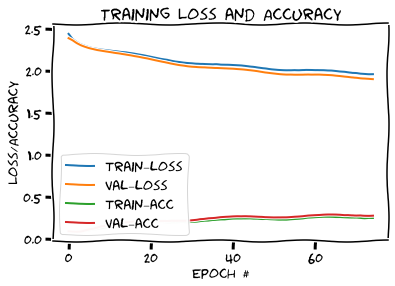

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75)
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [0]:
model.save("resnet_bn_only")
!gsutil -m cp -r resnet_bn_only gs://batch_norm

INFO:tensorflow:Assets written to: resnet_bn_only/assets
Copying file://resnet_bn_only/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
/ [4/4 files][  3.9 MiB/  3.9 MiB] 100% Done                                    
Operation completed over 4 objects/3.9 MiB.                                      


Epoch 1/75
391/391 [==============================] - 11s 29ms/step - loss: 2.3025 - accuracy: 0.1418 - val_loss: 2.2242 - val_accuracy: 0.1614
Epoch 2/75
391/391 [==============================] - 11s 28ms/step - loss: 2.2114 - accuracy: 0.1684 - val_loss: 2.1709 - val_accuracy: 0.1908
Epoch 3/75
391/391 [==============================] - 11s 28ms/step - loss: 2.1917 - accuracy: 0.1823 - val_loss: 2.1309 - val_accuracy: 0.2084
Epoch 4/75
391/391 [==============================] - 11s 28ms/step - loss: 2.1420 - accuracy: 0.2024 - val_loss: 2.0706 - val_accuracy: 0.2319
Epoch 5/75
391/391 [==============================] - 11s 28ms/step - loss: 2.1047 - accuracy: 0.2161 - val_loss: 2.0431 - val_accuracy: 0.2391
Epoch 6/75
391/391 [==============================] - 11s 28ms/step - loss: 2.0832 - accuracy: 0.2194 - val_loss: 2.0293 - val_accuracy: 0.2456
Epoch 7/75
391/391 [==============================] - 11s 28ms/step - loss: 2.0745 - accuracy: 0.2237 - val_loss: 2.0248 - val_accuracy:

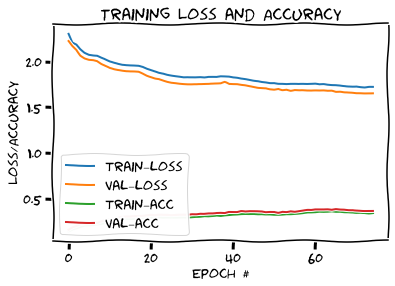

In [0]:
model = get_training_model()

for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        if hasattr(layer, "trainable"):
            layer.trainable=False

# Train model with a decay schedule
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate=0.1,
      first_decay_steps=first_decay_steps))

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr_decayed_fn), metrics=["accuracy"])

start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75)
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(h)

In [0]:
model.save("resnet_bn_only_2")
!gsutil -m cp -r resnet_bn_only_2 gs://batch_norm

INFO:tensorflow:Assets written to: resnet_bn_only_2/assets
Copying file://resnet_bn_only_2/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only_2/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only_2/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://resnet_bn_only_2/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
/ [4/4 files][  3.9 MiB/  3.9 MiB] 100% Done                                    
Operation completed over 4 objects/3.9 MiB.                                      
